In [7]:
!pip install deepface insightface facenet-pytorch mtcnn onnxruntime opencv-python-headless matplotlib pandas seaborn --quiet





In [2]:
!pip install onnxruntime --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.4 MB/s eta 0:00:00


In [5]:
import numpy as np, pandas as pd, cv2, time, os
from numpy.linalg import norm
import matplotlib.pyplot as plt, seaborn as sns
from deepface import DeepFace
from facenet_pytorch import MTCNN
from PIL import Image
from insightface.app import FaceAnalysis
from insightface.utils import face_align

def cosine_similarity(a,b):
    return float(np.dot(a,b)/(norm(a)*norm(b)))

def show_img(path, title="Image"):
    img=cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB)
    plt.imshow(img); plt.title(title); plt.axis("off"); plt.show()



Saving WhatsApp Image 2025-10-29 at 01.29.59_d3c3614a.jpg to WhatsApp Image 2025-10-29 at 01.29.59_d3c3614a (3).jpg
Saving WhatsApp Image 2025-10-29 at 01.06.30_07b7d07a.jpg to WhatsApp Image 2025-10-29 at 01.06.30_07b7d07a (6).jpg
Saving student1b.jpg to student1b (8).jpg
Uploaded: ['WhatsApp Image 2025-10-29 at 01.29.59_d3c3614a (3).jpg', 'WhatsApp Image 2025-10-29 at 01.06.30_07b7d07a (6).jpg', 'student1b (8).jpg']


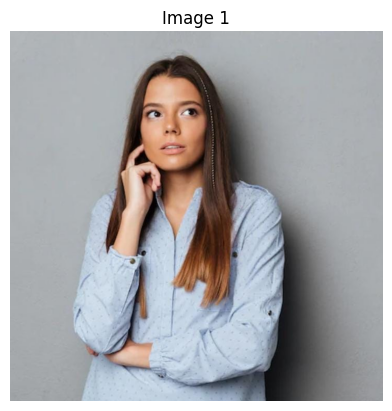

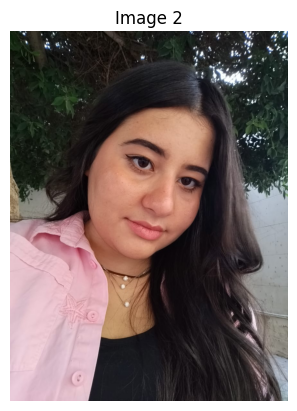

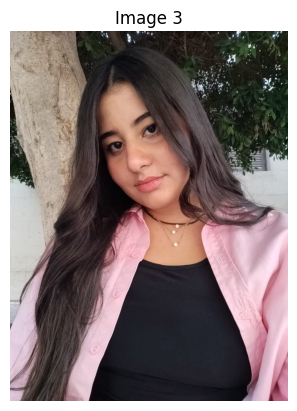

In [6]:
from google.colab import files
uploaded = files.upload()
img_paths = list(uploaded.keys())
print("Uploaded:", img_paths)
for i,p in enumerate(img_paths,1): show_img(p,f"Image {i}")




In [7]:
# --- for DeepFace models ---
mtcnn = MTCNN(keep_all=True)
def detect_crop(path, size=(160,160)):
    img = Image.open(path).convert('RGB')
    boxes,_ = mtcnn.detect(np.array(img))
    if boxes is None: return None
    areas=[(b[2]-b[0])*(b[3]-b[1]) for b in boxes]
    x1,y1,x2,y2 = map(int, boxes[np.argmax(areas)])
    face = np.array(img)[y1:y2, x1:x2]
    return cv2.resize(face, size)

# --- for ArcFace ---
app = FaceAnalysis(name="buffalo_l", providers=['CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640,640))
def align_arcface(path, size=(112,112)):
    img = cv2.imread(path)
    faces = app.get(img)
    if not faces:
        print(" No face in", path)
        return None
    faces.sort(key=lambda f:f.bbox[2]*f.bbox[3], reverse=True)
    f = faces[0]
    aligned = face_align.norm_crop(img, landmark=f.kps, image_size=size[0])
    return cv2.cvtColor(aligned, cv2.COLOR_BGR2RGB)



Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


In [9]:
models = ["Facenet","VGG-Face","OpenFace","DeepID"]
records = []

#DeepFace models
for m in models:
    try:
        t0 = time.time(); embs=[]
        for p in img_paths:
            face = detect_crop(p)
            if face is None: raise ValueError("no face")
            rep = DeepFace.represent(img_path=face, model_name=m, enforce_detection=False)[0]['embedding']
            e = np.array(rep); e /= (norm(e)+1e-10); embs.append(e)
        dt = round(time.time()-t0,2)
        s12,s13,s23 = [cosine_similarity(embs[i],embs[j]) for i in range(3) for j in range(i+1,3)]
        sims=[s12,s13,s23]; pairs=["1-2","1-3","2-3"]
        top = pairs[np.argmax(sims)]; topv = max(sims)
        dec = "STRONG SAME" if topv>0.7 else "POSSIBLE" if topv>0.5 else "DIFFERENT"
        records.append([m,len(embs[0]),dt,s12,s13,s23,top,round(topv,3),dec])
    except Exception as e:
        print(m,"failed:",e)

# ArcFace (InsightFace ONNX version)
from insightface.model_zoo import model_zoo
arc = model_zoo.get_model("buffalo_l", download=True)
arc.prepare(ctx_id=0)

aligned = [align_arcface(p) for p in img_paths]
embs=[]
for f in aligned:
    if f is not None:
        e = arc.get_feat(cv2.cvtColor(f, cv2.COLOR_RGB2BGR))
        e = np.squeeze(e)
        e = e / (norm(e)+1e-10)
        embs.append(e)


s12,s13,s23 = [cosine_similarity(embs[i],embs[j]) for i in range(3) for j in range(i+1,3)]
pairs=["1-2","1-3","2-3"]
vals=[s12,s13,s23]
top_idx=np.argmax(vals)
top_pair=pairs[top_idx]; top_val=vals[top_idx]
decision="STRONG SAME" if top_val>0.6 else "POSSIBLE" if top_val>0.45 else "DIFFERENT"
records.append(["ArcFace",len(embs[0]),None,s12,s13,s23,top_pair,round(top_val,3),decision])


⏳ Running comparisons...

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}


,Model,dim,time_s,s12,s13,s23,top_pair,top_val,decision
0,Facenet,128,3.04,-0.013134,-0.097494,0.803956,2-3,0.804,STRONG SAME
1,VGG-Face,4096,3.42,0.092586,0.128464,0.653490,2-3,0.653,POSSIBLE
2,OpenFace,128,1.83,0.561593,0.574993,0.837186,2-3,0.837,STRONG SAME
3,DeepID,160,1.45,0.907877,0.906980,0.860914,1-2,0.908,STRONG SAME
4,ArcFace,512,NaN,0.068503,0.078529,0.806459,2-3,0.806,STRONG SAME


📄 Saved: model_comparison_report.csv


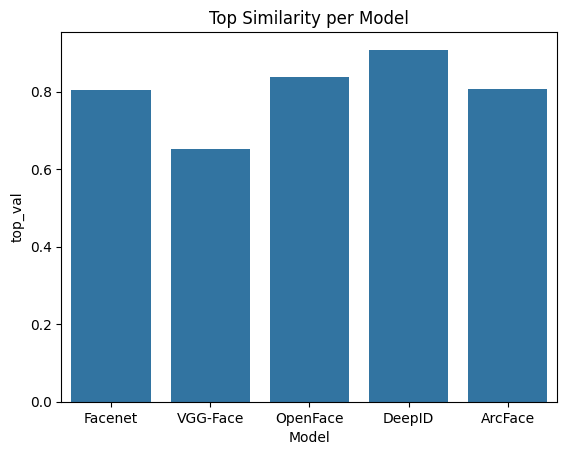

In [10]:
df = pd.DataFrame(records, columns=["Model","dim","time_s","s12","s13","s23","top_pair","top_val","decision"])
display(df)
df.to_csv("model_comparison_report.csv", index=False)
print(" Saved: model_comparison_report.csv")

sns.barplot(x="Model",y="top_val",data=df)
plt.title("Top Similarity per Model"); plt.show()
